### Test wtih JuMP

In [1]:
using JuMP , Ipopt
include("../Problems/JuMP/glider_JMP.jl")
GliderJMP = glider_JMP();

set_optimizer(GliderJMP,Ipopt.Optimizer)
set_attribute(GliderJMP, "print_level", 5)
set_optimizer_attribute(GliderJMP,"tol",1e-8)
set_optimizer_attribute(GliderJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(GliderJMP,"max_iter",1000)

In [4]:
println("Solving...")
optimize!(GliderJMP)
println()

# Display results
if termination_status(GliderJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(GliderJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(GliderJMP) == MOI.TIME_LIMIT && has_values(GliderJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(GliderJMP))
println()

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
N = 200
a = 100.0 
u_min, u_max = -pi/2.0, pi/2.0
xs = zeros(4)
xf = [NaN, 5.0, 45.0, 0.0]

x_ = GliderJMP[:x];
y_ = GliderJMP[:y];
x_dot = GliderJMP[:vx_dot];
y_dot = GliderJMP[:vy_dot];
u_ = GliderJMP[:cL];

con_x1 = GliderJMP[:x_eqn];
con_x2 = GliderJMP[:y_eqn];
con_x3 = GliderJMP[:vx_eqn];
con_x4 = GliderJMP[:vy_eqn];

tf = value(GliderJMP[:t_f])
Δtt = value.(tf)/N
t = Vector((0:N)*Δtt); 

p = [ [ dual(con_x1[1]), dual(con_x2[1]), dual(con_x3[1]), dual(con_x4[1]) ] ];
p = - [p; [[ dual(con_x1[i]), dual(con_x2[i]), dual(con_x3[i]), dual(con_x4[i]) ] for i in 1:N] ];



x1 = Vector(value.(x_))
x2 = Vector(value.(y_))
x3 = Vector(value.(x_dot))
x4 = Vector(value.(y_dot))
u = Vector(value.(u_)) ;

x =  [ [ x1[i], x2[i], x3[i], x4[i] ] for i in 1:N+1] ;


Solving...
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     6007
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    18800

Total number of variables............................:     1006
                     variables with only lower bounds:      403
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:      807
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3230000e+01 4.94e-01 2.00e+00  -1.0 0.00e+00    -  0.00e+0

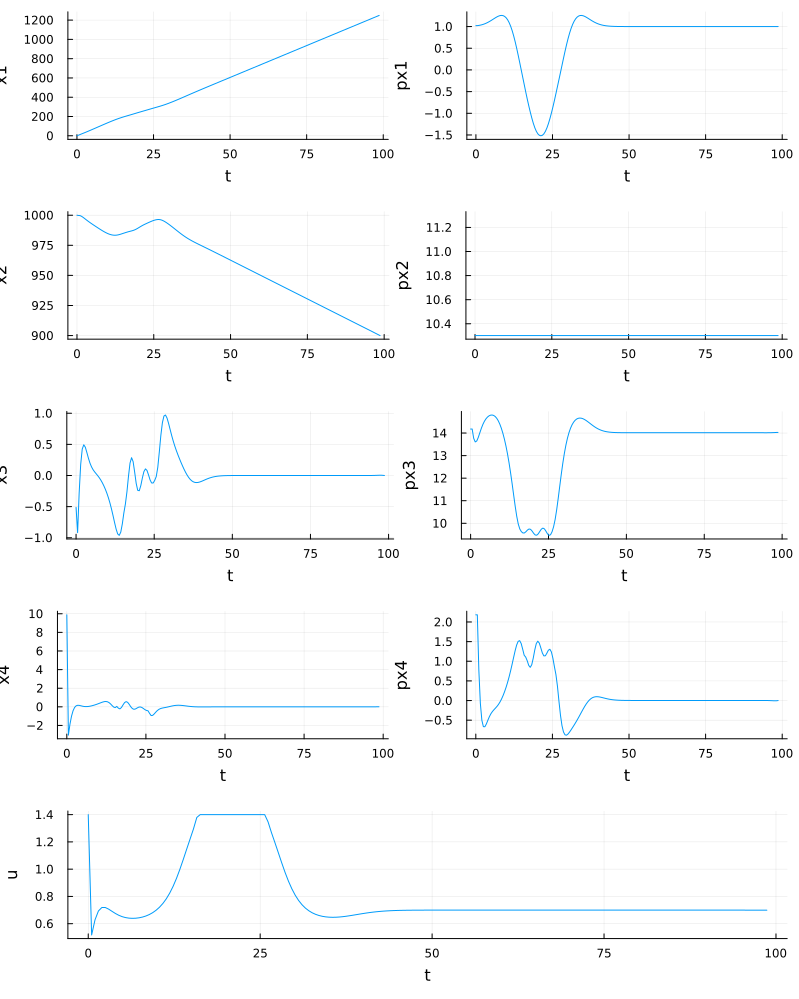

In [5]:
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N+1], xlabel = "t", ylabel = "x2", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false)
x4_plot = plot(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "x4", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false)
px4_plot = plot(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "px4", legend = false)
u_plot = plot(t, [ u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, x4_plot, px4_plot, u_plot, layout = layout, size = (800, 1000))
display(x_plot)

### Test with OptimalControl

In [2]:
using OptimalControl
include("../Problems/OptimalControl/glider_OC.jl")
GliderOC = glider_OC()


The (autonomous) optimal control problem is of the form:

    minimize  J(x, u, tf) = g(x(0.0), x(tf), tf)

    subject to

        ẋ(t) = f(x(t), u(t), tf), t in [0.0, tf] a.e.,

        ηl ≤ η(x(t), tf) ≤ ηu, 
        ϕl ≤ ϕ(x(0.0), x(tf), tf) ≤ ϕu, 

    where x(t) ∈ R⁴, u(t) ∈ R and tf ∈ R.

Declarations (* required):



┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ✅ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [ ]:
sol = OptimalControl.solve(GliderOC)

In [ ]:
using Plots
p1 = plot(plot(sol)[1])

p2 = plot(plot(sol)[2])

p3 = plot(plot(sol)[3])

p4 = plot(plot(sol)[4])

p5 = plot(plot(sol)[5])

p6 = plot(plot(sol)[6])

p7 = plot(plot(sol)[7])

p8 = plot(plot(sol)[8])

p9 = plot(plot(sol)[9])

layout = @layout [a b; c d; e f; g h; i]

x_plot = plot(p1, p5, p2, p6, p3, p7, p4, p8, p9, layout = layout)
x_plot = plot!(size = (700, 1000))

display(x_plot)

### Plot results

In [ ]:
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[4],line = 2)
p7 = plot!(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "x4", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[5],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[6],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[7],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false,line = 2, color = "red",linestyle=:dash)

p8 = plot(plot(sol)[8],line = 2)
p8 = plot!(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "px4", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[9] , label ="OC",line = 2)
p9 = plot!(t, [u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p9 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(p1, p2, p3, p4, p5, p6, p7 , p8, p9, layout = layout, size = (800, 1000))

display(x_plot)
